In [1]:
#Imports
import sys
sys.path.append("../")
import numpy
import matplotlib
from classes import ModelWrapper, DataLoader, Cluster, Vector

#Interactive matplotlib plots
%matplotlib widget

2024-03-01 11:09:26.500724: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Initialisation
modelAPI = ModelWrapper.loadPostprocessed("../models/3D/TPC_denoiser", "TPC_denoiser")
track_type = "alltracks"
data_loader = DataLoader("../data")
noisy = data_loader.getBatch(True, True, track_type=track_type, normalising=True)
noisy_with_E = data_loader.getBatch(True, True, track_type=track_type, normalising=False)
clean = data_loader.getBatch(True,False, track_type=track_type)
classified = modelAPI.classify( modelAPI.evaluateBatch(noisy) )
good_NN = Cluster.getGoodFromDataset(classified, noisy_with_E)
names = data_loader.getX17Names(track_type)

drift_v = 0.1*2 # cm / us
reference_axis = (0,0,1)

2024-03-01 11:09:29.953423: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


21/21 [==============================] - 6s 289ms/step


In [3]:
def getSpherical(a, b, reference_angle):
	'''Rotates line given by points @a, @b by angle @reference_angle in plane perpendicular to (GLOBAL)@reference_axis and returns tuple (rotated direction vector, polar angle, azimuthal angle).'''
	direction = Vector.linComb(-1, 1, a, b)
	direction = (direction[0], direction[1], direction[2]*drift_v)	# (x,y,t) -> (x,y,z)
	direction = Vector.multiply(1/Vector.norm(direction), direction)

	s, c = numpy.sin(reference_angle), numpy.cos(reference_angle)
	direction = (c*direction[0]-s*direction[2],direction[1],s*direction[0]+c*direction[2])
	if direction[2] < 0:	direction = Vector.multiply(-1, direction)

	#if direction[0] == 0 and direction[1] == 0: continue	#DELETE
	phi = numpy.arccos( Vector.dotProduct(direction, reference_axis) )	#polar

	theta = None
	if direction[0] != 0 or direction[1] != 0:
		theta = numpy.arccos(direction[0]/numpy.sqrt(direction[0]**2 + direction[1]**2))	#azimuthal
		if direction[1] < 0:	theta = - theta
	
	return (direction, phi, theta)

In [4]:
def getSphericalData(reference_angle, dataset, condition):
	'''Returns triple (direction vectors, polar angles, azimuthal angles)'''
	thetas = []
	phis = []
	directions = []

	for i in range(dataset.shape[0]):
		clusters = Cluster.clusterise(dataset[i])
		for cluster in clusters:
			cluster.setEnergy(noisy_with_E[i])
			cluster.runTests()
			if not condition:	continue
			try:
				a, b = cluster.linify()
			except:
				continue

			if a == b:	continue
			direction, phi, theta = getSpherical(a, b, reference_angle)

			phis.append(phi / numpy.pi * 180)
			directions.append(direction)
			if theta is not None:	thetas.append(theta / numpy.pi * 180)
	return (directions, phis, thetas)

/tmp/ipykernel_19050/488619111.py:23: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


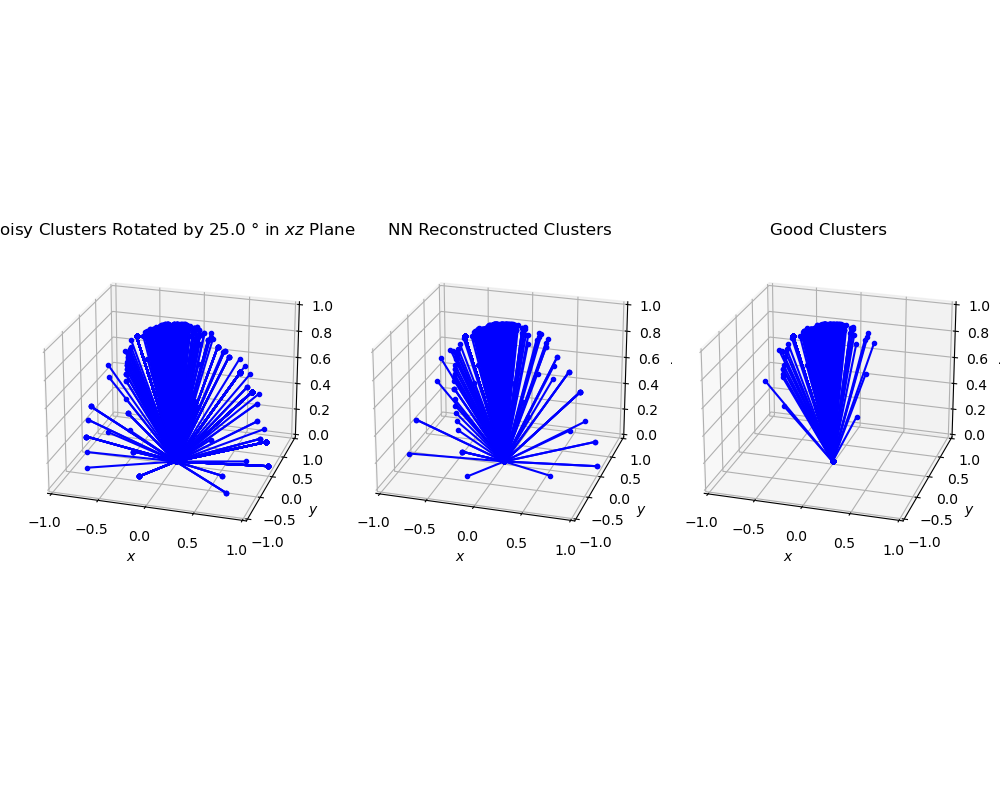

: 

In [10]:
#Compare 3D rays
reference_angle = 25/180*numpy.pi
directions = [None, None, None]
axes = [None, None, None]
titles = ["Noisy Clusters Rotated by "+ str(round(reference_angle / numpy.pi * 180,2)) + " ° in $xz$ Plane", "NN Reconstructed Clusters", "Good Clusters"]
directions[0], _, _ = getSphericalData(reference_angle, noisy, True)
directions[1], _, _ = getSphericalData(reference_angle, classified, True)
directions[2], _, _ = getSphericalData(reference_angle, good_NN, True)

fig = matplotlib.pyplot.figure(figsize=matplotlib.pyplot.figaspect(0.33))
for i in range(3):
	axes[i] = fig.add_subplot(1, 3, i+1, projection='3d')
	for v in directions[i]:
		ax = axes[i]
		ax.plot([0, v[0]], [0, v[1]], [0,v[2]], "b.-")
		ax.set_xlabel("$x$")
		ax.set_ylabel("$y$")
		ax.set_zlabel("$z$")
		ax.set_xlim(-1,1)
		ax.set_ylim(-1,1)
		ax.set_zlim(0,1)
		ax.set_title(titles[i])
		fig.tight_layout()
		fig.set_figwidth(10)
		fig.set_figheight(8)
		ax.view_init(23,-73,0)
matplotlib.pyplot.show()

In [ ]:

reference_angle = 0	#rotation angle
condition = True
thetas = []
phis = []
directions = []

for i in range(classified.shape[0]):
	clusters = Cluster.clusterise(classified[i])
	for cluster in clusters:
		cluster.setEnergy(noisy_with_E[i])
		cluster.runTests()
		if not condition:	continue
		try:
			a, b = cluster.linify()
		except:
			continue

		if a == b:	continue
		direction, phi, theta = getSpherical(a, b, reference_angle)

		phis.append(phi / numpy.pi * 180)
		directions.append(direction)
		thetas.append(theta)

		'''mass_centre = (0,0,0)
		n = 0
		for v in directions:
			mass_centre = Vector.add(mass_centre, v)
			n += 1
		mass_centre = Vector.multiply(1/n, mass_centre)
		print("angle", reference_angle / numpy.pi*180, "°, x mass_centre:", mass_centre[0])'''
		
		#3D RAYS
		'''fig = matplotlib.pyplot.figure(figsize=matplotlib.pyplot.figaspect(1))
		ax = fig.add_subplot(1, 1, 1, projection='3d')
		for v in directions:
			ax.plot([0, v[0]], [0, v[1]], [0,v[2]], "b.-")
		ax.set_xlabel("$x$")
		ax.set_ylabel("$y$")
		ax.set_zlabel("$z$")
		ax.set_xlim(-1,1)
		ax.set_ylim(-1,1)
		ax.set_zlim(0,1)
		ax.set_title("NN Reconstructed Tracks Rotated by " + str(round(reference_angle / numpy.pi * 180,2)) + " ° in $xz$ Plane")
		#ax.set_title("NN Reconstructed Tracks")
		fig.tight_layout()
		fig.set_figwidth(10)
		fig.set_figheight(8)
		ax.view_init(23,-73,0)
		matplotlib.pyplot.show()'''
		
		#2D PROJECTION
		'''matplotlib.pyplot.scatter([v[0] for v in directions], [v[1] for v in directions])
		matplotlib.pyplot.xlabel("$x$")
		matplotlib.pyplot.ylabel("$y$")
		matplotlib.pyplot.xlim(-1,1)
		matplotlib.pyplot.ylim(-1,1)
		matplotlib.pyplot.title("NN Reconstructed Tracks (Taken as Vectors) Rotated by " + str(round(reference_angle / numpy.pi * 180,2)) + " ° in $xz$ Plane\n $xy$ Projection")
		matplotlib.pyplot.show()'''

		#2D PROJECTION TWO SETS
		'''fig, ax = matplotlib.pyplot.subplots(1,2)
		ax[0].scatter([v[0] for v in directions], [v[1] for v in directions])
		ax[1].scatter([v[0] for v in directions_special], [v[1] for v in directions_special])
		for i in range(2):
			ax[i].set_xlabel("$x$")
			ax[i].set_ylabel("$y$")
			ax[i].set_xlim(-1,1)
			ax[i].set_ylim(-1,1)
		ax[0].set_title("Nonspecial")
		ax[1].set_title("Special")
		matplotlib.pyplot.show()
		exit()'''

		'''ax.view_init(30,0,0)
		def run(i):	
				ax.view_init(30,i,0)

		anim = matplotlib.animation.FuncAnimation(fig, func=run, frames=360, interval=20, blit=False)
		anim.save("./anim.gif", fps=30, dpi=400, writer="pillow")
		
		exit()'''

		#PHI VS THETA SCATTER
		'''matplotlib.pyplot.scatter(thetas, phis)
		matplotlib.pyplot.xlabel("Azimuthal")
		matplotlib.pyplot.ylabel("Polar")
		matplotlib.pyplot.xlim(-190,190)
		matplotlib.pyplot.ylim(0,90)
		matplotlib.pyplot.title("Polar vs Azimuthal Angle, NN Reconstructed + Test-filtered Tracks \nRotated by " + str(round(reference_angle / numpy.pi * 180,2)) + " ° in $xz$ Plane")
		matplotlib.pyplot.show()'''

		#PHI + THETA HISTOGRAMS
		fig, ax = matplotlib.pyplot.subplots(1,2)
		fig.set_figwidth(10)
		fig.set_figheight(8)
		ax[0].hist(phis, bins=15)
		ax[1].hist(thetas, bins=15)
		ax[0].set_xlabel(r"$\phi [°]$")
		ax[1].set_xlabel(r"$\theta [°]$")
		ax[0].set_ylabel("#")
		ax[1].set_ylabel("#")
		ax[0].set_title("Track Polar Angle Distribution (w.r.t. $z$)")
		ax[1].set_title("Track $xy$ Azimuthal Angle Distribution (w.r.t. $x$)")
		ax[0].set_xlim(0,90)
		ax[1].set_xlim(-180,180)
		fig.suptitle("Tracks Reconstructed by NN Passing > 2 Tests and Rotated by " + str(round(reference_angle / numpy.pi * 180,2)) + " ° in $xz$ Plane", fontsize="x-large")
		fig.tight_layout()
		matplotlib.pyplot.show()
		#if round(reference_angle / numpy.pi * 180,2) in [0,1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45]:
		#	matplotlib.pyplot.savefig("./imgs/angular_analysis/azimuthal_polar/NN_" + str(round(reference_angle / numpy.pi * 180,0)) + "deg.png")
		#matplotlib.pyplot.close()